In [27]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg

seaborn.set()
plt.style.use('./matplotlibrc')

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [3]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  scipy.sparse.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)

Число обусловленности такой матрицы будет большим

In [4]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w) / min(w)

(406095.04265001946, 406095.0425928014)

In [5]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [16]:
def PreconditionedCG(x0, A, b, max_iters, tol=1e-8, callback=None):
    n = len(b)
    D = scipy.sparse.diags(A.diagonal())
    M = scipy.sparse.tril(A) @ scipy.sparse.linalg.inv(D) @ scipy.sparse.triu(A)
    
    x = x0.copy()
    r_last = b - A @ x
    z = scipy.sparse.linalg.spsolve(M, r_last)
    p = z
    w = A @ p
    alpha = np.dot(r_last, z) / np.dot(p, w)
    x += alpha * p
    r = r_last - alpha * w
    
    for _ in range(max_iters):
        if np.linalg.norm(r) < tol:
            break
        
        z_last = z.copy()
        z = scipy.sparse.linalg.spsolve(M, r)
        beta = np.dot(r, z) / np.dot(r_last, z_last)
        p = z + beta * p
        w = A @ p
        alpha = np.dot(r, z) / np.dot(p, w)
        x += alpha * p
        r_last = r.copy()
        r -= alpha * w
        
        if callback is not None:
            callback(x)
    
    return x


def ConjugateGradient(x0, A, b, max_iters, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    
    for _ in range(max_iters):
        if np.linalg.norm(r) < tol:
            break
        
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        
        if callback is not None:
            callback(x)
            
    return x


result_preconditioned = PreconditionedCG(x0, A, b, 1000)
result_base = ConjugateGradient(x0, A, b, 1000)
np.linalg.norm(A @ result_preconditioned - b), np.linalg.norm(A @ result_base - b)

(3.706944952825124e-08, 8.585380407478326e-07)

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

/home/egork/PythonVenvs/DataScience/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/egork/PythonVenvs/DataScience/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


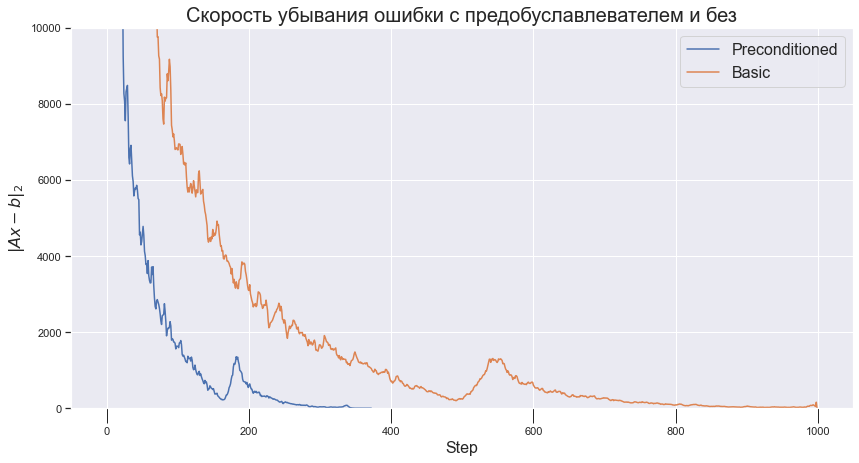

In [23]:
history_preconditioned = []
history_base = []

PreconditionedCG(x0, A, b, 1000, callback=lambda x: history_preconditioned.append(np.linalg.norm(A @ x - b)))
ConjugateGradient(x0, A, b, 1000, callback=lambda x: history_base.append(np.linalg.norm(A @ x - b)))

fig = plt.figure()

plt.plot(np.arange(len(history_preconditioned)), history_preconditioned, label='Preconditioned')
plt.plot(np.arange(len(history_base)), history_base, label='Basic')

plt.legend()
plt.title('Скорость убывания ошибки с предобуславлевателем и без')
plt.xlabel('Step')
plt.ylabel(r'$| Ax - b |_2$')
plt.ylim((0, 10 ** 4))

plt.show()

Сравните результат работы предобусловленной и непредобусловленной версии

**Вывод:** Предобусловленная в разы круче

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [55]:
np.random.seed(23)
n = 100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-5, 5, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

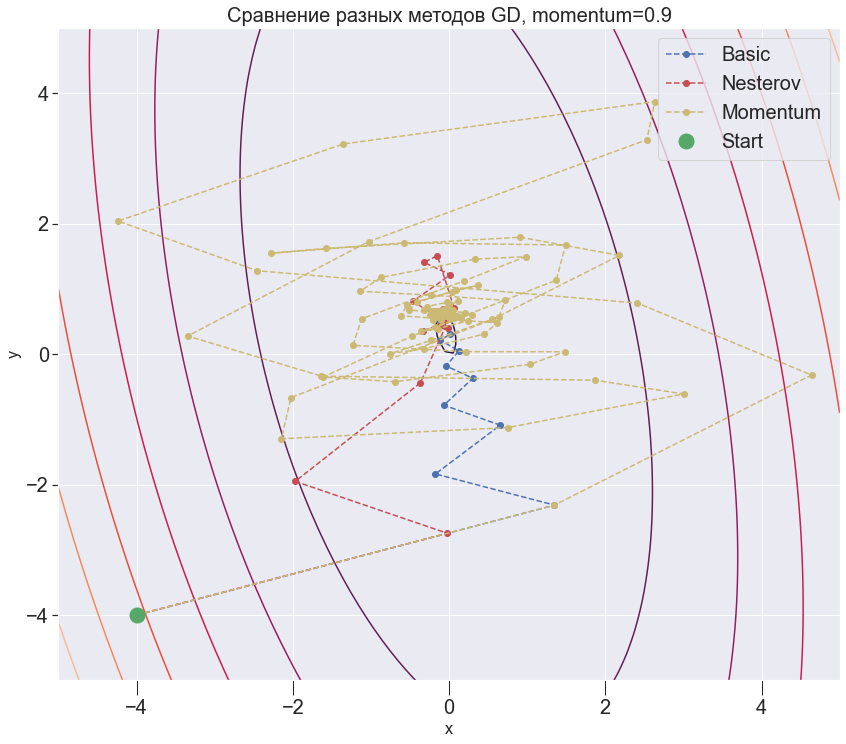

In [58]:
import types


def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha


#Callback и в  GD и в CG написан по убогому, поэтому этот костыль для рисования графика
def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)


def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

    while True:
        beta2 = 1. -beta1
        #TO DO
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        #END TO DO
        iteration += 1
        
        if np.linalg.norm(gradf(x)) < tol:
            break
            
        if iteration >= max_iter:
            break
            
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    
    return res


def NesterovAcceleratedGD(f, gradf, x0, momentum=0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:
        beta2 = 1. -beta1
        #TO DO
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        #END TO DO
        iteration += 1
        
        if np.linalg.norm(gradf(x)) < tol:
            break
            
        if iteration >= max_iter:
            break
            
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    
    return res


def MomentumGD(f, gradf, x0, momentum=0.9, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []
    change = np.zeros(x.shape)

    while True:
        beta2 = 1. - beta1
        #TO DO
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        change = momentum * change - alpha * gradient
        x = x + change
        #END TO DO
        iteration += 1
        
        if np.linalg.norm(gradf(x)) < tol:
            break
            
        if iteration >= max_iter:
            break
            
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    
    return res



basic_res = GradientDescent(f, grad_f, x0)
nesterov_res = NesterovAcceleratedGD(f, grad_f, x0, momentum=0.9)
momentum_res = MomentumGD(f, grad_f, x0, momentum=0.9)

x_basic, y_basic = get_x_y_from_callback(basic_res["conv_array"], x0)
x_nesterov, y_nesterov = get_x_y_from_callback(nesterov_res["conv_array"], x0)
x_momentum, y_momentum = get_x_y_from_callback(momentum_res["conv_array"], x0)

plt.figure(figsize=(14, 12))

plt.plot(x_basic, y_basic, '--bo', label='Basic')
plt.plot(x_nesterov, y_nesterov, '--ro', label='Nesterov')
plt.plot(x_momentum, y_momentum, '--yo', label='Momentum')
plt.plot(x0[0], x0[1], 'go', markersize=15, label='Start')

plt.contour(x, y, f_x)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение разных методов GD, momentum=0.9')
plt.legend(loc="best", fontsize=20)

plt.show()

In [59]:
print('Скорости сходимости, momentum=0.9')
print()

print('Обычный GD:', len(basic_res["conv_array"]))
print('GD с моментом Нестерова:', len(nesterov_res["conv_array"]))
print('GD с простым моментом:', len(momentum_res["conv_array"]))

Скорости сходимости, momentum=0.9

Обычный GD: 49
GD с моментом Нестерова: 84
GD с простым моментом: 383


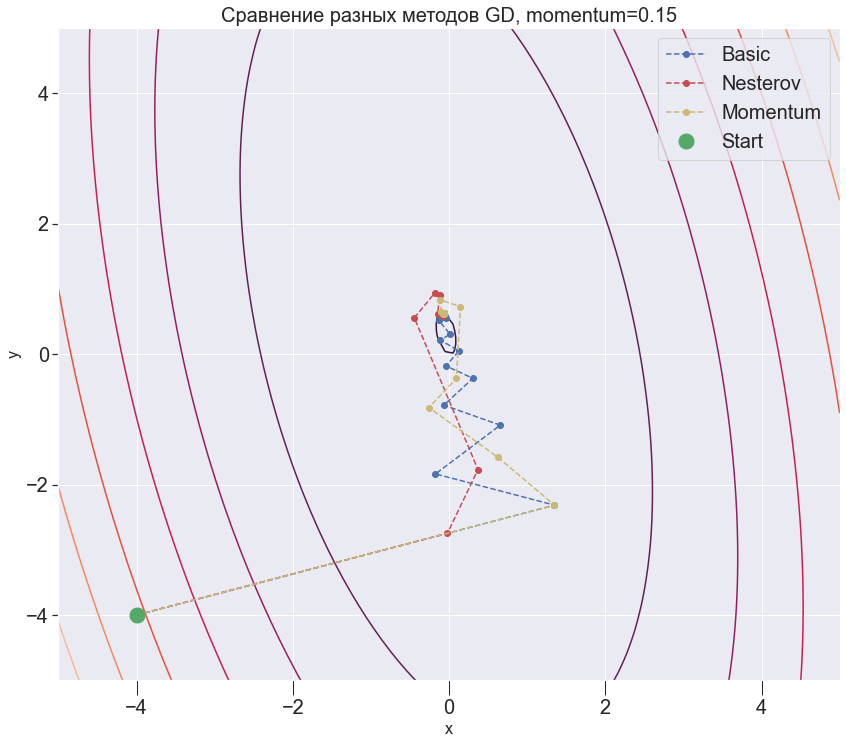

In [60]:
basic_res = GradientDescent(f, grad_f, x0)
nesterov_res = NesterovAcceleratedGD(f, grad_f, x0, momentum=0.15)
momentum_res = MomentumGD(f, grad_f, x0, momentum=0.15)

x_basic, y_basic = get_x_y_from_callback(basic_res["conv_array"], x0)
x_nesterov, y_nesterov = get_x_y_from_callback(nesterov_res["conv_array"], x0)
x_momentum, y_momentum = get_x_y_from_callback(momentum_res["conv_array"], x0)

plt.figure(figsize=(14, 12))

plt.plot(x_basic, y_basic, '--bo', label='Basic')
plt.plot(x_nesterov, y_nesterov, '--ro', label='Nesterov')
plt.plot(x_momentum, y_momentum, '--yo', label='Momentum')
plt.plot(x0[0], x0[1], 'go', markersize=15, label='Start')

plt.contour(x, y, f_x)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение разных методов GD, momentum=0.15')
plt.legend(loc="best", fontsize=20)

plt.show()

In [61]:
print('Скорости сходимости, momentum=0.15')
print()

print('Обычный GD:', len(basic_res["conv_array"]))
print('GD с моментом Нестерова:', len(nesterov_res["conv_array"]))
print('GD с простым моментом:', len(momentum_res["conv_array"]))

Скорости сходимости, momentum=0.15

Обычный GD: 49
GD с моментом Нестерова: 30
GD с простым моментом: 25


**Вывод:**

Если брать слишком большой момент - 0.9, то обычный GD лучше всего, а простой момент просто ужасен.

Но если брать небольшой момент - 0.15, то все ровно наоборот.

Нестеров в обоих случаях посередине.